In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from diffusers import DDPMScheduler, UNet2DModel
import numpy as np
import accelerate
torch.device('cuda' if torch.cuda.is_available() else 'cpu') # this wi

device(type='cuda')

In [25]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
cifar_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)


indices = [i for i, label in enumerate(cifar_dataset.targets) if label in [0, 1]]
cifar_dataset.targets = [cifar_dataset.targets[i] for i in indices]
cifar_dataset.data = cifar_dataset.data[indices]


if len(cifar_dataset) == 0:
    raise ValueError("The dataset is empty after filtering. Check the filtering logic.")


train_size = int(0.8 * len(cifar_dataset))
test_size = len(cifar_dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(cifar_dataset, [train_size, test_size])


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

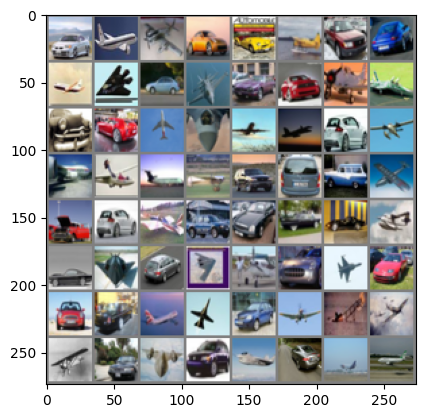

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
images, labels = next(iter(train_loader))
imshow(torchvision.utils.make_grid(images))


In [27]:
model = UNet2DModel.from_pretrained("google/ddpm-cifar10-32")
scheduler = DDPMScheduler.from_pretrained("google/ddpm-cifar10-32")

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


In [28]:
def apply_diffusion(image, t):

    noise = torch.randn_like(image)
    timestep = int(t * scheduler.num_train_timesteps)
    timestep_tensor = torch.tensor([timestep], device=image.device)
    noisy_image = scheduler.add_noise(image, noise, timestep_tensor)
    return noisy_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


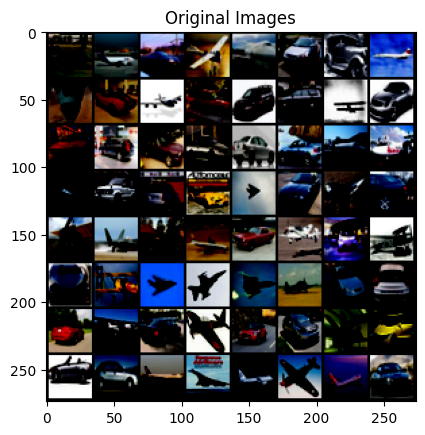

/home/janis/EAP2/Dynamical-Regimes-of-Diffusion-Models/.venv/lib/python3.11/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.5292034..4.2255945].


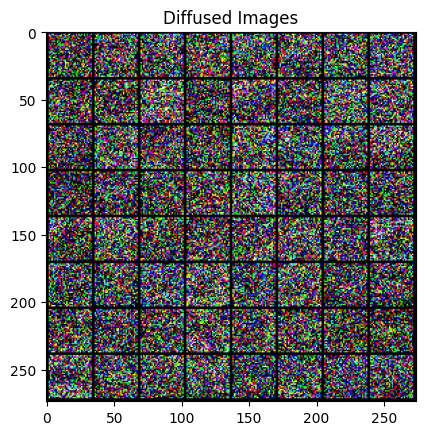

In [29]:
images, labels = next(iter(train_loader))


plt.imshow(np.transpose(torchvision.utils.make_grid(images).numpy(), (1, 2, 0)))
plt.title("Original Images")
plt.show()
diffused_images = apply_diffusion(images, 0.5)
plt.imshow(np.transpose(torchvision.utils.make_grid(diffused_images).numpy(), (1, 2, 0)))
plt.title("Diffused Images")
plt.show()


In [30]:
from tqdm import tqdm

def denoise(noisy_image, t):
    model.eval()
    
    start_timestep = int(t * scheduler.num_train_timesteps)
    num_denoising_steps = start_timestep
    
    timestep_tensor = torch.tensor([start_timestep], device=noisy_image.device)

    denoised_image = noisy_image
    for step in tqdm(range(num_denoising_steps)):
        current_timestep = start_timestep - int((start_timestep / num_denoising_steps) * step)
        timestep_tensor = torch.tensor([current_timestep], device=noisy_image.device)

        with torch.no_grad():
            predicted_noise = model(denoised_image, timestep_tensor).sample

        denoised_image = scheduler.step(predicted_noise, timestep_tensor, denoised_image).prev_sample

    return denoised_image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5775406..1.6747857].


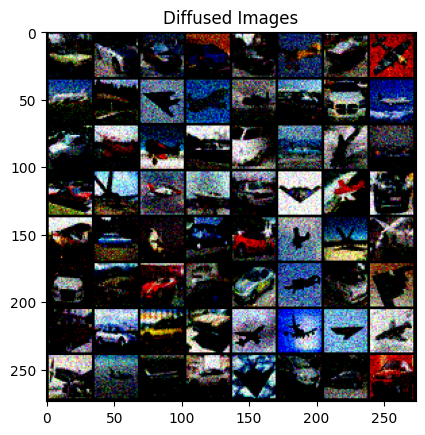

100%|██████████| 50/50 [01:42<00:00,  2.04s/it]
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0352328..1.0441828].


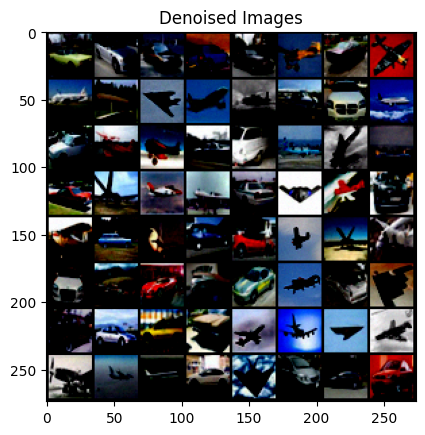

In [31]:
images, labels = next(iter(train_loader))
diffused_images = apply_diffusion(images, 0.05)
plt.imshow(np.transpose(torchvision.utils.make_grid(diffused_images).numpy(), (1, 2, 0)))
plt.title("Diffused Images")
plt.show()
denoised_images = denoise(diffused_images, 0.05)
plt.imshow(np.transpose(torchvision.utils.make_grid(denoised_images).numpy(), (1, 2, 0)))
plt.title("Denoised Images")
plt.show()

In [32]:
from tqdm import tqdm

class LinearClassifier(nn.Module):
    def __init__(self):
        super(LinearClassifier, self).__init__()
        self.fc = nn.Linear(3 * 32 * 32, 2)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

classifier = LinearClassifier()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)
classifier.train()

for epoch in range(5):
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = classifier(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 200 == 199:
            print(f"[{epoch + 1}, {i + 1}] loss: {running_loss / 200}")
            running_loss = 0.0

print("Finished training the classifier.")

classifier.eval()
correct = 0
total = 0

with torch.no_grad():
    for data in test_loader:
        images, labels = data
        outputs = classifier(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Accuracy of the classifier on the test dataset: {100 * correct / total}%")

125it [00:00, 126.02it/s]
125it [00:01, 123.50it/s]
125it [00:01, 114.18it/s]
125it [00:00, 132.42it/s]
125it [00:00, 127.23it/s]


Finished training the classifier.
Accuracy of the classifier on the test dataset: 78.75%


In [33]:
def evaluate_diffusion_denoising(t):
    classifier.eval()
    correct_original = 0
    correct_denoised = 0
    with torch.no_grad():
        for i, data in enumerate(test_loader):
            if i >= 5:
                break
            images, labels = data
            diffused_images = apply_diffusion(images, t)
            denoised_images = denoise(diffused_images, t)
            outputs_original = classifier(images)
            _, predicted_original = torch.max(outputs_original.data, 1)
            correct_original += (predicted_original == labels).sum().item()
            outputs_denoised = classifier(denoised_images)
            _, predicted_denoised = torch.max(outputs_denoised.data, 1)
            correct_denoised += (predicted_denoised == labels).sum().item()
    accuracy_original = correct_original / 100
    accuracy_denoised = correct_denoised / 100
    return accuracy_original, accuracy_denoised

accuracy_original, accuracy_denoised = evaluate_diffusion_denoising(0.05)
print(f"Accuracy of the classifier on the original images: {accuracy_original * 100}%")
print(f"Accuracy of the classifier on the denoised images: {accuracy_denoised * 100}%")

accuracy_original, accuracy_denoised = evaluate_diffusion_denoising(0.5)
print(f"Accuracy of the classifier on the original images: {accuracy_original * 100}%")
print(f"Accuracy of the classifier on the denoised images: {accuracy_denoised * 100}%")

accuracy_original, accuracy_denoised = evaluate_diffusion_denoising(0.95)


  0%|          | 0/50 [00:00<?, ?it/s]

  6%|▌         | 3/50 [00:07<01:59,  2.54s/it]


KeyboardInterrupt: 